In [1]:
import pandas as pd
import sys

In [2]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars, na_plot
#from utilsPlots import get_indexes_from_list, get_elements_from_list
#from utilsPlots import plot_anova_vs_mi

In [3]:
# load data
df_train = pd.read_csv('data/train.csv')
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [4]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [5]:
# duplicated samples
dupl = sum(df_train.duplicated(['PassengerId']))
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


In [6]:
# TODO Some Name are duplicated
sum(df_train[~df_train['Name'].isna()].duplicated(['Name']))

20

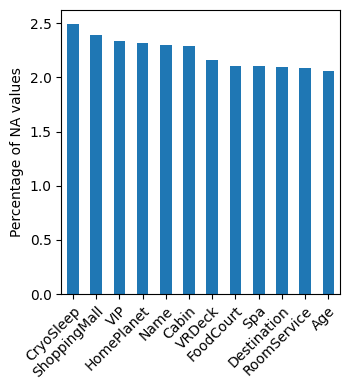

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [7]:
# NAs values
na_plot(df_train)
# distribution of NAs in samples
print(df_train.isnull().sum())

In [30]:
# distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


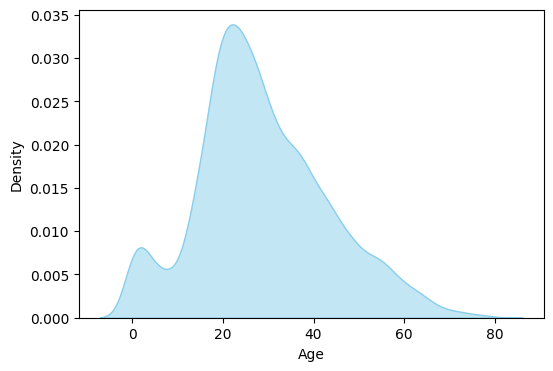

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


In [11]:
# visualize 'Age' feature
plot_density(df_train, ['Age'], 1, 1)
print(df_train['Age'].describe())

In [23]:
# people with CryoSleep True have no expenses
df_train[df_train['CryoSleep'] == True][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

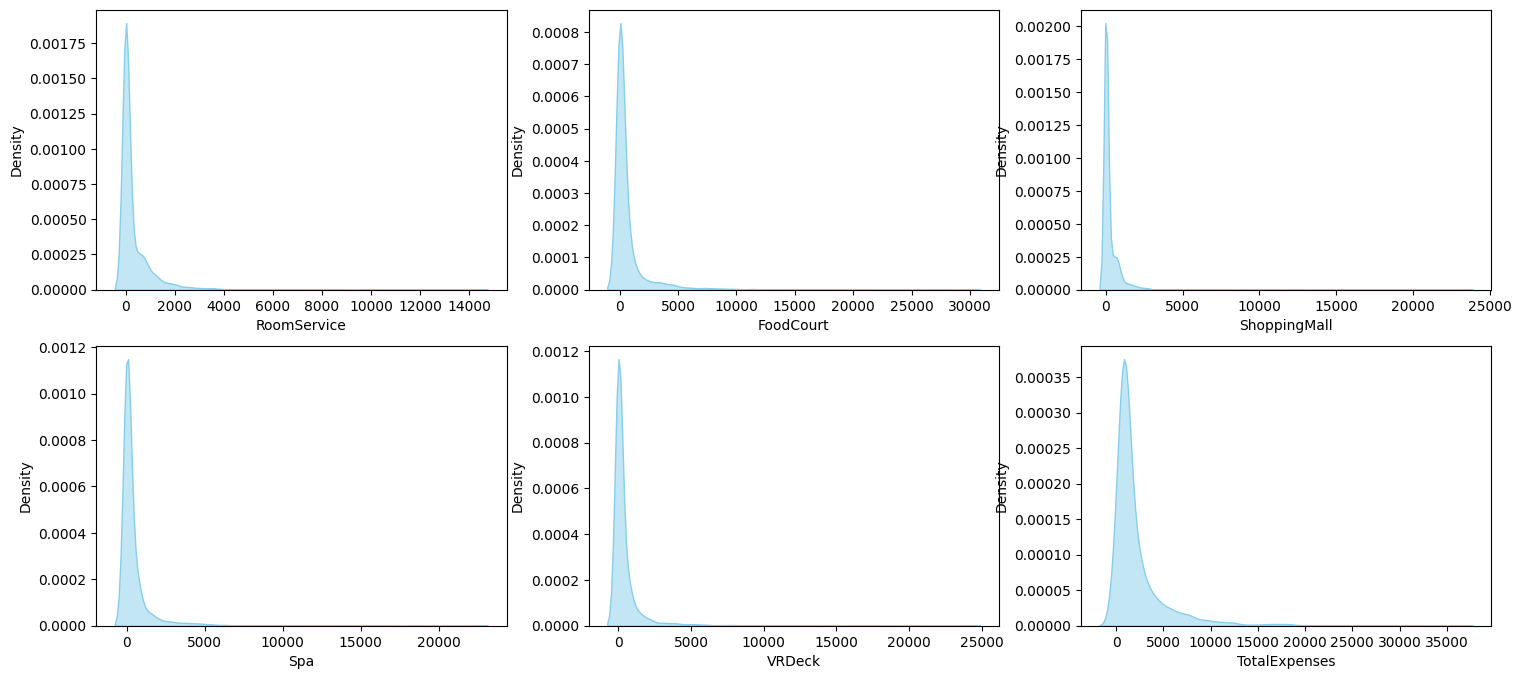

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   5328.000000   5329.000000   5335.000000   5326.000000   5320.000000   
mean     350.146772    713.004316    270.586504    486.092940    475.716165   
std      803.080320   1970.547985    741.756155   1396.233751   1404.174304   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        3.000000      5.000000      2.000000      7.000000      4.000000   
75%      390.250000    537.000000    242.000000    354.750000    356.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

       TotalExpenses  
count    5439.000000  
mean     2248.299687  
std      3245.061489  
min         0.000000  
25%       746.000000  
50%      1019.000000  
75%      2416.000000  
max     35987.000000  


In [27]:
# visualize 'RoomService', 'FoodCourt', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
df = df_train[df_train['CryoSleep'] == False][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
df['TotalExpenses'] = df.sum(axis=1)
plot_density(df, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','TotalExpenses'], 2, 3)
print(df.describe())

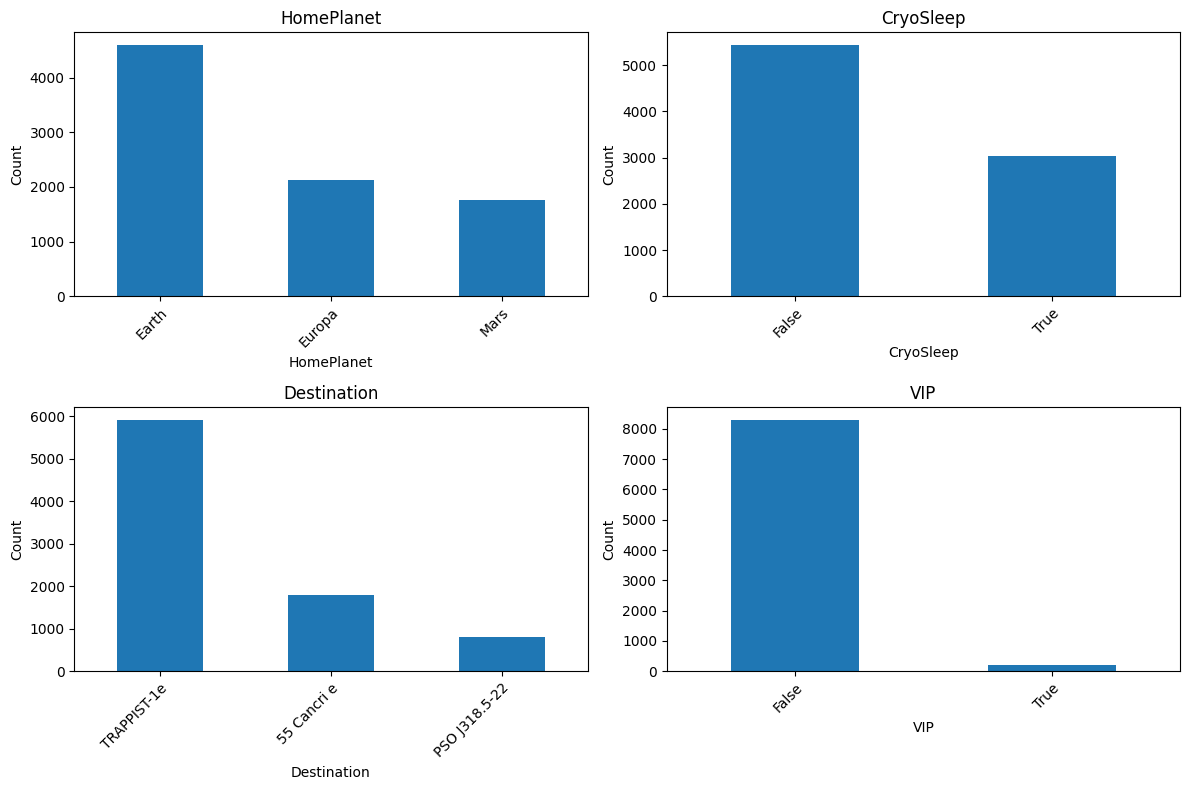

In [4]:
# visualize HomePlanet, CryoSleep, Destination, VIP
plot_bars(df_train, ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], 2, 2, sort = True, log = False)

In [2]:
# TODO Show Num in different format (table describe)
# TODO Correlation between explanatory features
# TODO Correlation explanatory features vs target
# TODO Quantitative Standarization
# TODO Qualitative Encoding? Grouping?
# TODO Feature engineering
# TODO Imputate NA values (several inputation methods)
# TODO Imputation for CryoSleep: no expenses --> True
# TODO Imputation for Expenses: CryoSleep True --> 0
# TODO Use only TotalExpenses feature?
# TODO Convert TotalExpenses to binary feature ('Low', 'High')
# TODO Something to do with Name?
# TODO Imputation:
# 1. To most common
# 2. 'Unknown'
# 3. Mean --> Age
# 4. Predict Age from available data
# 5. Remove


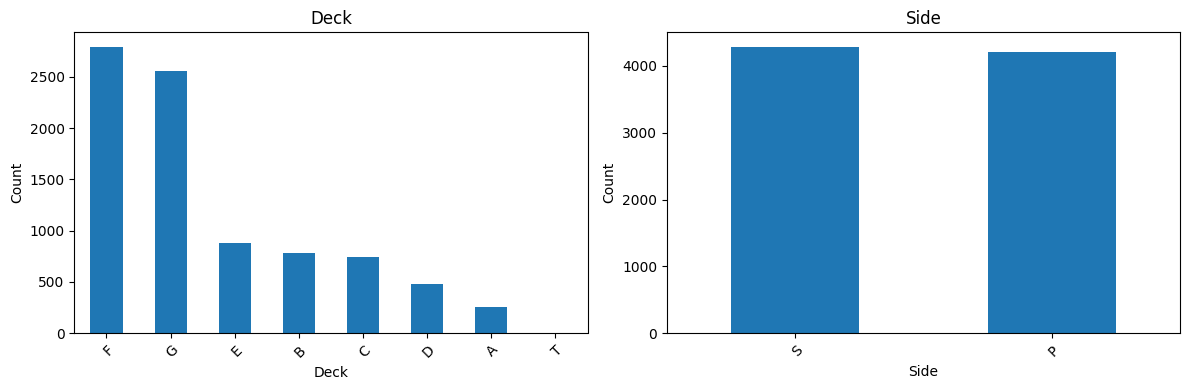

In [14]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)
df_train['Num'] = df_train['Num']
# visualize Cabin splitting
plot_bars(df_train, ['Deck', 'Side'], 1, 2, sort = True, log = False)
# TODO df_train['Num'].astype(int).describe()